In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    SBJ = np.array([])
    Cond = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta = prms['delta'].values[i]
        t0_sp = prms['t0_sp'].values[i]
        t0_ac = prms['t0_ac'].values[i]
        
        if model == 'exp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp * np.exp(-lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac * np.exp(-lamda_ac*t)
        elif model == 'hyp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp / (1 + lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac / (1 + lamda_ac*t)
        elif model == 'ddm':
            b0_sp = prms['b0_sp'].values[i]
            b0_ac = prms['b0_ac'].values[i]
            ub_sp = lambda t: b0_sp
            ub_ac = lambda t: b0_ac
            
        lb_sp = lambda t: -1*ub_sp(t)
        lb_ac = lambda t: -1*ub_ac(t)

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)

        rt = []
        cond = []

        for _ in range(300):
            cond.append('SP')
            rt.append(simulate_CDDM(ub_sp, lb_sp, delta, ndt=t0_sp))
            cond.append('AC')
            rt.append(simulate_CDDM(ub_ac, lb_ac, delta, ndt=t0_ac))

        RT = np.concatenate([RT, rt])
        Cond = np.concatenate([Cond, cond])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'cond':Cond,
                         'rt': np.abs(RT),
                         'accuracy': RT>0}) 

In [4]:
data = pd.read_csv('../../../_Data/Study2.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data['Duration']<data['RT']].reset_index(drop=True)

data['RT']/=1000
data['Duration']/=1000

data_speed = data[data.cue == 'SP'].reset_index(drop=True)
data_accuracy = data[data.cue == 'AC'].reset_index(drop=True)

In [5]:
jhyp = pd.read_csv('_prms/hyp.csv')
jexp = pd.read_csv('_prms/exp.csv')
jddm = pd.read_csv('_prms/jddm.csv')
bhyp = pd.read_csv('_prms/bhyp.csv')
bexp= pd.read_csv('_prms/bexp.csv')
bddm= pd.read_csv('_prms/bddm.csv')

In [6]:
pred_jhyp = get_model_prediction(jhyp, data, 'hyp')

100%|███████████████████████████████████████████████| 25/25 [00:10<00:00,  2.42it/s]


In [7]:
pred_bhyp = get_model_prediction(bhyp, data, 'hyp')

100%|███████████████████████████████████████████████| 25/25 [00:10<00:00,  2.32it/s]


In [8]:
pred_jexp = get_model_prediction(jexp, data, 'exp')

100%|███████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]


In [9]:
pred_bexp = get_model_prediction(bexp, data, 'exp')

100%|███████████████████████████████████████████████| 25/25 [00:15<00:00,  1.62it/s]


In [10]:
pred_jddm = get_model_prediction(jddm, data, 'ddm')

100%|███████████████████████████████████████████████| 25/25 [00:08<00:00,  3.02it/s]


In [11]:
pred_bddm = get_model_prediction(bddm, data, 'ddm')

100%|███████████████████████████████████████████████| 25/25 [00:07<00:00,  3.18it/s]


In [12]:
def plot_model_pred(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 25)
    if var == 'rt':
        temp = pred.groupby(by=['sbj'])[var].mean()
        plt.errorbar(x= x, 
                     y= pred[var].mean(),
                     yerr=err*temp.values.std()/np.sqrt(25), 
                     label=label, c=color);
        plt.scatter(x= x, 
                    y= pred[var].mean(), color=color);
    else:
        temp = pred.groupby(by=['sbj'])[var].mean()
        plt.errorbar(x= x, 
                     y= pred[var].mean(),
                     yerr=err*temp.values.std()/np.sqrt(25), 
                     label=label, c=color);
        plt.scatter(x= x, 
                    y= pred[var].mean(), color=color);

In [13]:
def plot_rt_quantiles(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 25)
    for q in [0.1, 0.3, 0.5, 0.7, 0.9]:
        quantiles = pred.groupby(by=['sbj'])[var].quantile(q)
        plt.errorbar(x= 10*q + x, 
                     y= quantiles.mean(),
                     yerr=err*quantiles.std()/np.sqrt(25), 
                     label=label, c=color);
        plt.scatter(x=10*q + x, y=quantiles.mean(), color=color)

In [14]:
c_data = '#2A628F'
c_jhyp = '#C8D5B9'
c_jexp = '#8FC0A9'
c_jddm = '#C0D7BB'
c_bhyp = '#7D82B8'
c_bexp = '#628395'
c_bddm = '#4BA3C3'

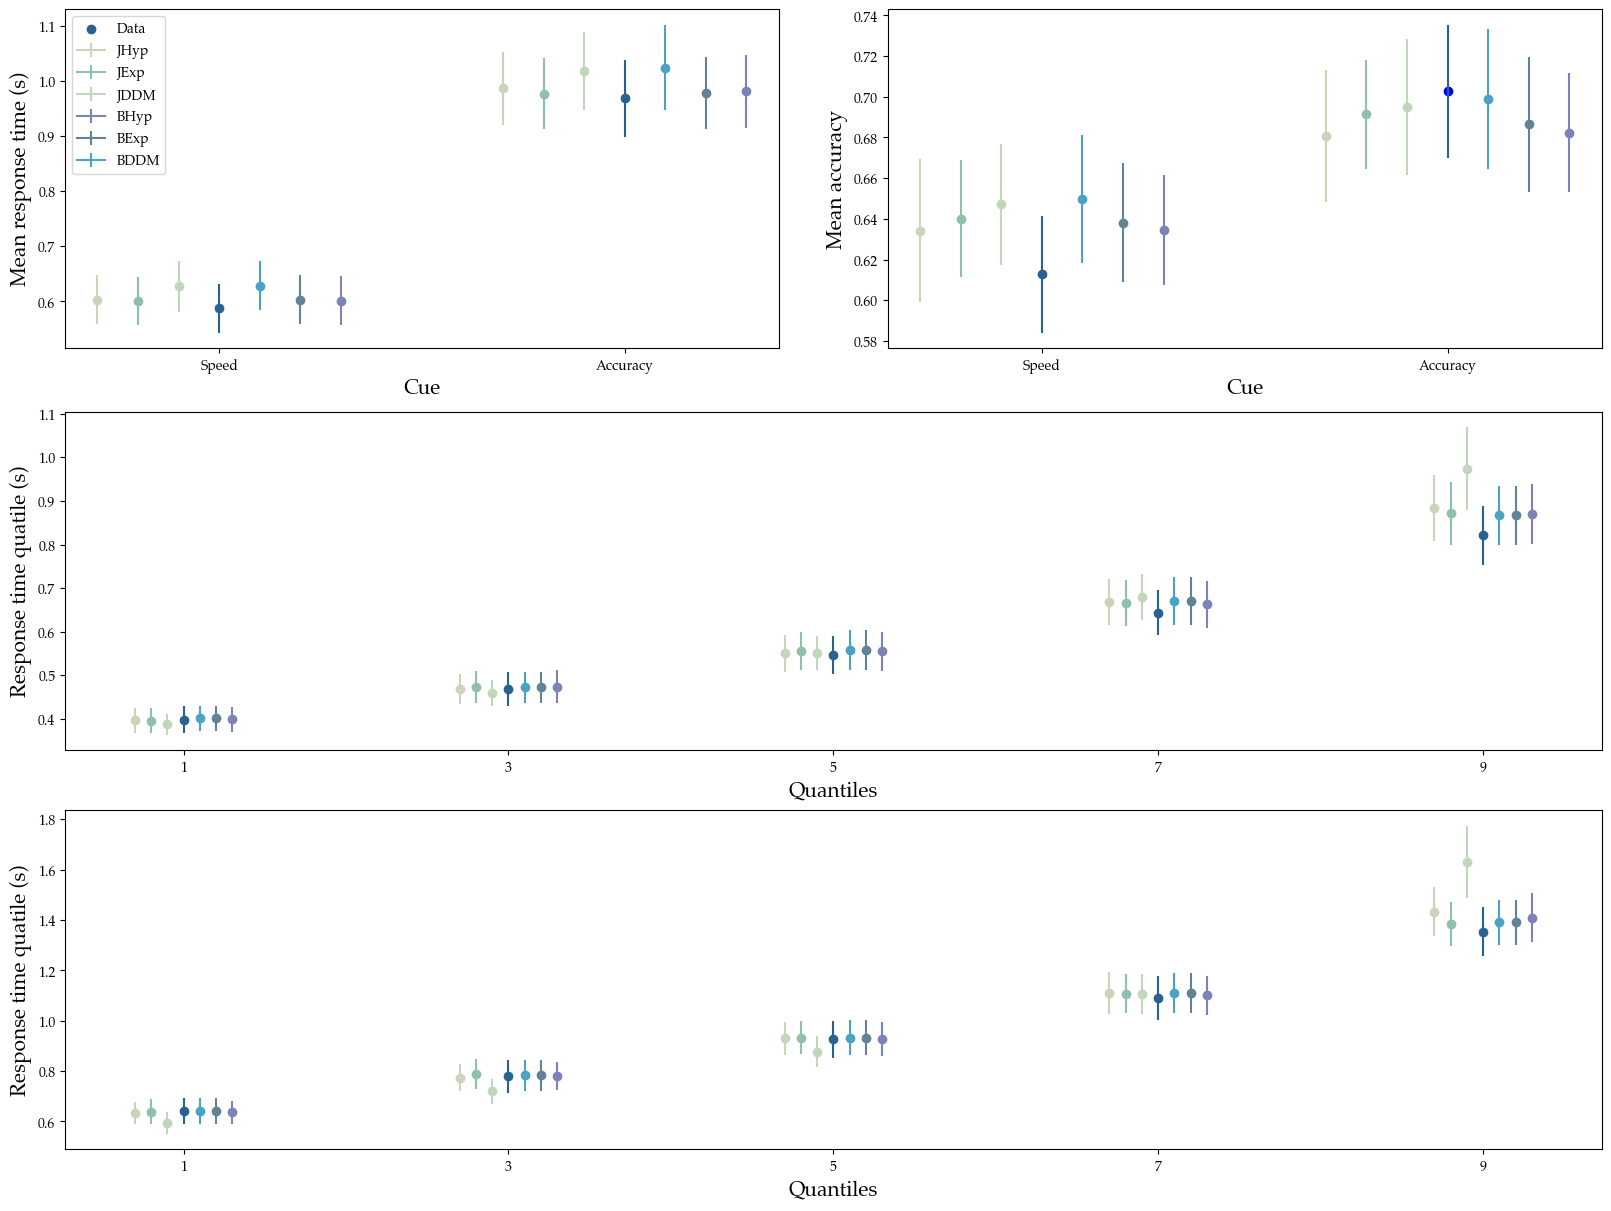

In [15]:
fig = plt.figure(figsize=(16, 12), layout='constrained')

gs = GridSpec(3, 2, figure=fig)

fig.add_subplot(gs[0, 0])
plot_model_pred(pred_jhyp[pred_jhyp['cond']=='SP'], 'rt', c_jhyp, -3, 'JHyp')
plot_model_pred(pred_jexp[pred_jexp['cond']=='SP'], 'rt', c_jexp, -2, 'JExp')
plot_model_pred(pred_jddm[pred_jddm['cond']=='SP'], 'rt', c_jddm, -1, 'JDDM')
plot_model_pred(pred_bhyp[pred_bhyp['cond']=='SP'], 'rt', c_bhyp,  3, 'BHyp')
plot_model_pred(pred_bexp[pred_bexp['cond']=='SP'], 'rt', c_bexp,  2, 'BExp')
plot_model_pred(pred_bddm[pred_bddm['cond']=='SP'], 'rt', c_bddm,  1, 'BDDM')

plot_model_pred(pred_jhyp[pred_jhyp['cond']=='AC'], 'rt', c_jhyp, 7, None)
plot_model_pred(pred_jexp[pred_jexp['cond']=='AC'], 'rt', c_jexp, 8, None)
plot_model_pred(pred_jddm[pred_jddm['cond']=='AC'], 'rt', c_jddm, 9, None)
plot_model_pred(pred_bhyp[pred_bhyp['cond']=='AC'], 'rt', c_bhyp, 13, None)
plot_model_pred(pred_bexp[pred_bexp['cond']=='AC'], 'rt', c_bexp, 12, None)
plot_model_pred(pred_bddm[pred_bddm['cond']=='AC'], 'rt', c_bddm, 11, None)

err = scipy.stats.t.ppf(0.975, 25)
temp = data_speed.groupby(by=['participant'])['RT'].mean()
plt.errorbar(x=0, y=data_speed['RT'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c=c_data);
plt.scatter(x=0, 
            y=data_speed['RT'].mean(), 
            c=c_data, label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time', fontsize=15)

temp = data_accuracy.groupby(by=['participant'])['RT'].mean()
plt.errorbar(x=10, y=data_accuracy['RT'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c=c_data);
plt.scatter(x=10, 
            y=data_accuracy['RT'].mean(), 
            c=c_data);
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend();
plt.xticks([0, 10], ['Speed', 'Accuracy']);

fig.add_subplot(gs[0, 1])
plot_model_pred(pred_jhyp[pred_jhyp['cond']=='SP'], 'accuracy', c_jhyp, -3, 'JHyp')
plot_model_pred(pred_jexp[pred_jexp['cond']=='SP'], 'accuracy', c_jexp, -2, 'JExp')
plot_model_pred(pred_jddm[pred_jddm['cond']=='SP'], 'accuracy', c_jddm, -1, 'JDDM')
plot_model_pred(pred_bhyp[pred_bhyp['cond']=='SP'], 'accuracy', c_bhyp,  3, 'BHyp')
plot_model_pred(pred_bexp[pred_bexp['cond']=='SP'], 'accuracy', c_bexp,  2, 'BExp')
plot_model_pred(pred_bddm[pred_bddm['cond']=='SP'], 'accuracy', c_bddm,  1, 'BDDM')

plot_model_pred(pred_jhyp[pred_jhyp['cond']=='AC'], 'accuracy', c_jhyp, 7, None)
plot_model_pred(pred_jexp[pred_jexp['cond']=='AC'], 'accuracy', c_jexp, 8, None)
plot_model_pred(pred_jddm[pred_jddm['cond']=='AC'], 'accuracy', c_jddm, 9, None)
plot_model_pred(pred_bhyp[pred_bhyp['cond']=='AC'], 'accuracy', c_bhyp, 13, None)
plot_model_pred(pred_bexp[pred_bexp['cond']=='AC'], 'accuracy', c_bexp, 12, None)
plot_model_pred(pred_bddm[pred_bddm['cond']=='AC'], 'accuracy', c_bddm, 11, None)

err = scipy.stats.t.ppf(0.975, 25)
temp = data_speed.groupby(by=['participant'])['correct'].mean()
plt.errorbar(x=0, y=data_speed['correct'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c=c_data);
plt.scatter(x=0, 
            y=data_speed['correct'].mean(), 
            c=c_data, label='Data');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15)

temp = data_accuracy.groupby(by=['participant'])['correct'].mean()
plt.errorbar(x=10, y=data_accuracy['correct'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c=c_data);
plt.scatter(x=10, 
            y=data_accuracy['correct'].mean(), 
            c='blue');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15)
plt.xticks([0, 10], ['Speed', 'Accuracy']);

fig.add_subplot(gs[1, :])
plot_rt_quantiles(pred_jhyp[pred_jhyp['cond']=='SP'], 'rt', c_jhyp, -0.3, 'JHyp')
plot_rt_quantiles(pred_jexp[pred_jexp['cond']=='SP'], 'rt', c_jexp, -.2, 'JExp')
plot_rt_quantiles(pred_jddm[pred_jddm['cond']=='SP'], 'rt', c_jddm, -.1, 'JDDM')
plot_rt_quantiles(pred_bhyp[pred_bhyp['cond']=='SP'], 'rt', c_bhyp, .3, 'BHyp')
plot_rt_quantiles(pred_bexp[pred_bexp['cond']=='SP'], 'rt', c_bexp, .2, 'BExp')
plot_rt_quantiles(pred_bexp[pred_bddm['cond']=='SP'], 'rt', c_bddm, .1, 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
for q in [0.1, 0.3, 0.5, 0.7, 0.9]:
    quantiles = data_speed.groupby(by=['participant'])['RT'].quantile(q)
    plt.errorbar(x= 10*q, 
                 y= quantiles.mean(),
                 yerr=err*quantiles.std()/np.sqrt(26), 
                 label='Data', c=c_data);
    plt.scatter(x=10*q, y=quantiles.mean(), color=c_data)
plt.xticks([1, 3, 5, 7, 9], [1, 3, 5, 7, 9]);
plt.ylabel('Response time quatile (s)', fontsize=15);
plt.xlabel('Quantiles', fontsize=15);

fig.add_subplot(gs[2, :])
plot_rt_quantiles(pred_jhyp[pred_jhyp['cond']=='AC'], 'rt', c_jhyp, -0.3, 'JHyp')
plot_rt_quantiles(pred_jexp[pred_jexp['cond']=='AC'], 'rt', c_jexp, -.2, 'JExp')
plot_rt_quantiles(pred_jddm[pred_jddm['cond']=='AC'], 'rt', c_jddm, -.1, 'JDDM')
plot_rt_quantiles(pred_bhyp[pred_bhyp['cond']=='AC'], 'rt', c_bhyp, .3, 'BHyp')
plot_rt_quantiles(pred_bexp[pred_bexp['cond']=='AC'], 'rt', c_bexp, .2, 'BExp')
plot_rt_quantiles(pred_bexp[pred_bddm['cond']=='AC'], 'rt', c_bddm, .1, 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
for q in [0.1, 0.3, 0.5, 0.7, 0.9]:
    quantiles = data_accuracy.groupby(by=['participant'])['RT'].quantile(q)
    plt.errorbar(x= 10*q, 
                 y= quantiles.mean(),
                 yerr=err*quantiles.std()/np.sqrt(26), 
                 label='Data', c=c_data);
    plt.scatter(x=10*q, y=quantiles.mean(), color=c_data)
plt.xticks([1, 3, 5, 7, 9], [1, 3, 5, 7, 9]);
plt.ylabel('Response time quatile (s)', fontsize=15);
plt.xlabel('Quantiles', fontsize=15);

plt.savefig('S2_preds.pdf', 
            transparent=True, 
            dpi=600, 
            bbox_inches='tight');